# Analyse Model results
Notebook for experimental tests of analyzing model results. Methods that were successfull are incorporated into the other Notebooks

(This Notebook is not relevant for the Thesis)

In [1]:
# import necessary libraries
import importlib.util
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing, metrics
import plotly.express as px
import plotly.graph_objs as go

In [2]:
# import general Utiltiy Functions Module as gUF
spec = importlib.util.spec_from_file_location("generalUtilityFunctions.py","C:/Users/leonf/Documents/Python/Masterthesis-Leon/Utility_Functions/generalUtilityFunctions.py")
gUF = importlib.util.module_from_spec(spec)
spec.loader.exec_module(gUF)

Load the Data

In [3]:
option_data = 6

if option_data == 1: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/DATA_daily.pkl")
    info_data =  "Not Imputed Dataset"
if option_data == 2: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_daily_AVwC.pkl")
    info_data = "AVwC Dataset"
if option_data == 3: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_daily_NRM_d.pkl")
    info_data = "NRM_d Dataset"
if option_data == 4: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_daily_IDW.pkl")
    info_data = "IDW Dataset"
if option_data == 5: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_daily_LR.pkl")
    info_data = "LR Dataset"
if option_data == 6: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/DATA_daily_inside.pkl")
    info_data = "NRM_d Dataset only Stations inside Catchment"
if option_data == 7: # switch to hourly values from here on 
    DATA = pd.read_pickle('C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/DATA.pkl')
    info_data = "Hourly Data - Not Imputed"
if option_data == 8: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_hourly_AVwC.pkl")
    info_data = "Hourly Data - AVwC"
if option_data == 9: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_hourly_NRM_d.pkl")
    info_data = "Hourly Data - NRM_d"
if option_data == 10: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_hourly_IDW.pkl")
    info_data = "Hourly Data - IDW"
if option_data == 11: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Imputed_tables/DATA_hourly_LR.pkl")
    info_data = "Hourly Data - LR"
if option_data == 12: 
    DATA = pd.read_pickle("C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/DATA_hourly_inside.pkl")
    info_data = "Hourly Data - LR only Stations inside Catchment"

In [4]:
# Larsim Data
data_basis = "daily"
Larsim_simulations_daily = pd.read_pickle('C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/Larsim_simulations_daily.pkl')
Larsim_simulations_hourly = pd.read_pickle('C:/Users/leonf/Documents/Python/Masterthesis-Leon/DATA/Created_tables/Larsim_simulations.pkl')

if data_basis == "daily":
    Larsim_simulations = Larsim_simulations_daily
if data_basis == "hourly":
    Larsim_simulations = Larsim_simulations_hourly

In [5]:
# choose if target station is included as input feature
with_target = True

# choose, if all usable discharge gauges should be used as additional input
with_discharge = False

if with_discharge == False:
    # Drop Discharge Stations and rearange the dataframe (last column: target values --> discharge at Marienthal(MARI)
    timestamps = DATA.index.values
    target_feature = ("q", "MARI")
    target_values = DATA.T[DATA.columns.isin([target_feature])].T
    # Model_data => Final Dataframe, that contains only the Data that should be fed into the NN
    model_data = DATA.drop(columns="q", level="Parameter")
    model_data = pd.concat([model_data, target_values], axis="columns", join="outer", levels="Parameter")
    # impute missing values in target/ discharge --> linear interpolation
    model_data["q", "MARI"].interpolate(method="time", axis=0, limit=None, inplace=True, limit_direction="both")
    df = model_data.copy()

if with_discharge == True and option_data < 7: # Daily Data
    # Drop Discharge Stations and rearange the dataframe (last column: target values --> discharge at Marienthal(MARI))
    timestamps = DATA.index.values
    target_feature = ('q','MARI')
    target_values = DATA.T[DATA.columns.isin([target_feature])].T
    # Model_data => Final Dataframe, that contains only the Data that should be fed into the NN
    model_data = DATA.drop(columns='MARI', level='Stationskennung')
    model_data.columns.set_levels(['n', 'q_in', 'rflu', 'tlu_min', 'tlu_max', 'ttau', 'xglob', 'xludr', 'xwind', 'zsos'], level= 0, inplace= True )
    model_data = pd.concat([model_data, target_values], axis='columns', join= 'outer', levels= 'Parameter')
    # impute missing values in target/ discharge --> linear interpolation
    model_data['q','MARI'].interpolate(method='time', axis=0, limit=None, inplace=True, limit_direction='both')
    df = model_data.copy()

if with_discharge == True and option_data >= 7: # Hourly Data
    # Drop Discharge Stations and rearange the dataframe (last column: target values --> discharge at Marienthal(MARI))
    timestamps = DATA.index.values
    target_feature = ('q','MARI')
    target_values = DATA.T[DATA.columns.isin([target_feature])].T
    # Model_data => Final Dataframe, that contains only the Data that should be fed into the NN
    model_data = DATA.drop(columns='MARI', level='Stationskennung')
    model_data.columns.set_levels(['n', 'q_in', 'rflu', 'tlu', 'ttau', 'xglob', 'xludr', 'xwind', 'zsos'], level= 0, inplace= True )
    model_data = pd.concat([model_data, target_values], axis='columns', join= 'outer', levels= 'Parameter')
    # impute missing values in target/ discharge --> linear interpolation
    model_data['q','MARI'].interpolate(method='time', axis=0, limit=None, inplace=True, limit_direction='both')
    df = model_data.copy()

In [6]:
df.shape

(4739, 33)

In [9]:
# General Settings --> adapt according to daily/hourly data
shuffle_buffer = 10000
WINDOW_SIZE = 120       # Vishakh: 120
BATCH_SIZE = 20         # Vishakh: 10
target_step = 1     # predict next day

In [10]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Prepocess the datasets (dependent on Method for Missing Values)


In [9]:
# Missing Values - Method 1
# df = model_data.copy()
# df = df.dropna(axis=0)

# # Splitting the Dataset by Size
# training_size = int(len(df) * 0.70)
# validation_size = int(len(df) * 0.19)
# train_dataset, val_dataset, test_dataset = gUF.train_val_test_split(df, (training_size, validation_size), None, validation=True)

# # Scale the data
# # scaler = preprocessing.RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0), copy=True)
# scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
# train_dataset_scaled = scaler.fit_transform(train_dataset) 
# val_dataset_scaled = scaler.transform(val_dataset)
# test_dataset_scaled = scaler.transform(test_dataset)

# # Split Training/Validation/Test Dataset into input features and target values/labels
# train_x, train_y = gUF.windowed_data(train_dataset_scaled, train_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)
# val_x, val_y = gUF.windowed_data(val_dataset_scaled, val_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)
# test_x, test_y = gUF.windowed_data(test_dataset_scaled, test_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)

# # Combine resulting features and lables into one Tensor consisting of shuffled batches
# training_data = gUF.batched_dataset(train_x, train_y, BATCH_SIZE, shuffle_buffer, 'training', repeat=False)
# validation_data = gUF.batched_dataset(val_x, val_y, BATCH_SIZE, shuffle_buffer, 'validation', repeat=False)
# testing_data = gUF.batched_dataset(test_x, test_y, BATCH_SIZE, shuffle_buffer, 'testing', repeat=False)

In [11]:
# Missing Values - Method 2 and 3
if with_target == True:
    # Splitting the Dataset by Size
    training_size = int(len(df) * 0.70)
    validation_size = int(len(df) * 0.19)
    train_dataset, val_dataset, test_dataset = gUF.train_val_test_split(df, (training_size, validation_size), None, validation=True)

    # Scale the data
    scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
    train_dataset_scaled = scaler.fit_transform(train_dataset) 
    val_dataset_scaled = scaler.transform(val_dataset)
    test_dataset_scaled = scaler.transform(test_dataset)

    # Fill values after Scaling
    fill_value = -7.0
    np.nan_to_num(train_dataset_scaled, copy= False, nan= fill_value)
    np.nan_to_num(val_dataset_scaled, copy= False, nan= fill_value)
    np.nan_to_num(test_dataset_scaled, copy= False, nan= fill_value)

    # Split Training/Validation/Test Dataset into input features and target values/labels
    train_x, train_y = gUF.windowed_data(train_dataset_scaled, train_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)
    val_x, val_y = gUF.windowed_data(val_dataset_scaled, val_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)
    test_x, test_y = gUF.windowed_data(test_dataset_scaled, test_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)

    # Combine resulting features and lables into one Tensor consisting of shuffled batches
    training_data = gUF.batched_dataset(train_x, train_y, BATCH_SIZE, shuffle_buffer, 'training', repeat=True)
    validation_data = gUF.batched_dataset(val_x, val_y, BATCH_SIZE, shuffle_buffer, 'validation', repeat=True)
    testing_data = gUF.batched_dataset(test_x, test_y, BATCH_SIZE, shuffle_buffer, 'testing', repeat=True)
else: 
    # Missing Values - Method 2 and 3 (TARGET EXCLUDED)
    # Splitting the Dataset by Size
    training_size = int(len(df) * 0.70)
    validation_size = int(len(df) * 0.19)
    train_dataset, val_dataset, test_dataset = gUF.train_val_test_split(df, (training_size, validation_size), None, validation=True)

    # Scale the data
    scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
    train_dataset_scaled = scaler.fit_transform(train_dataset) 
    val_dataset_scaled = scaler.transform(val_datset)
    test_dataset_scaled = scaler.transform(test_dataset)

    # Fill values after Scaling
    fill_value = -7.0
    np.nan_to_num(train_dataset_scaled, copy= False, nan= fill_value)
    np.nan_to_num(val_dataset_scaled, copy= False, nan= fill_value)
    np.nan_to_num(test_dataset_scaled, copy= False, nan= fill_value)

    # Split Training/Validation/Test Dataset into input features and target values/labels
    train_x, train_y = gUF.windowed_data(train_dataset_scaled[:,:-1], train_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)
    val_x, val_y = gUF.windowed_data(val_dataset_scaled[:,:-1], val_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)
    test_x, test_y = gUF.windowed_data(test_dataset_scaled[:,:-1], test_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)

    # Combine resulting features and lables into one Tensor consisting of shuffled batches
    training_data = gUF.batched_dataset(train_x, train_y, BATCH_SIZE, shuffle_buffer, 'training', repeat=True)
    validation_data = gUF.batched_dataset(val_x, val_y, BATCH_SIZE, shuffle_buffer, 'validation', repeat=True)
    testing_data = gUF.batched_dataset(test_x, test_y, BATCH_SIZE, shuffle_buffer, 'testing', repeat=True) 

In [12]:
# Prepare the larsim simulation data
if data_basis == "daily":
    Larsim_train, Larsim_val, Larsim_test = gUF.train_val_test_split(Larsim_simulations_daily['MARI'], (training_size, validation_size), None,  validation=True)
if data_basis == "hourly":
    Larsim_train, Larsim_val, Larsim_test = gUF.train_val_test_split(Larsim_simulations_hourly['MARI'], (training_size, validation_size), None,  validation=True)

In [13]:
# OPTIONAL
# checking the number of necessary(minimum) evaluation steps and validation steps --> This Cell is only needed when the input Dataset is a Repeated Dataset 
# Ensure that the whole the different datasets are used completely: steps_per_epoch = (len(dataset) - WINDOW_SIZE)//(BATCH_SIZE)
steps_in_one_epoch = (len(train_dataset) - WINDOW_SIZE)//(BATCH_SIZE)
print(steps_in_one_epoch)
validation_steps_after_one_epoch = (len(val_dataset) - WINDOW_SIZE)//(BATCH_SIZE)
print(validation_steps_after_one_epoch)
testing_steps = (len(test_dataset) - WINDOW_SIZE)//(BATCH_SIZE)
print(testing_steps)

# Set the evaluation interval manually --> steps (batches of samples = batch_size * steps)
# default values --> each batch of samples of the datasets are exaclty shown once to the model 
TRAINING_INTERVAL = steps_in_one_epoch
VALUATION_INTERVAL = validation_steps_after_one_epoch
TEST_INTERVAL = testing_steps

159
39
20


In [14]:
# Load a model (!check if configurations are fit the settings above!)
path = "C:/Users/leonf/Documents/Python/Masterthesis-Leon/Models/Saved_models/model_config-Loss_MAE_Window_120_L-Units_120_L-Layers_2/"
dataset = "Dataset_6_Scale_1_Method_2_Validation_1"

model = tf.keras.models.load_model(path + dataset)

Evaluate the Model on Windowed Dataset

In [15]:
# EVALUATION On windowed Datasets (numpy arrays)
# Evaluate the Model -> train_x
print('-------Training----------\n')
results_train = model.evaluate(x= train_x, y= train_y, verbose= 0, batch_size= BATCH_SIZE)
result_dict_train = dict(zip(model.metrics_names, results_train))
for key, value in result_dict_train.items():
  print(key, ":", round(value,5))

print('\n-------Validation----------\n')
# Evaluate the Model -> val_x
results_val = model.evaluate(x= val_x, y= val_y, verbose= 0, batch_size= BATCH_SIZE)
result_dict_val = dict(zip(model.metrics_names, results_val))
for key, value in result_dict_val.items():
  print(key, ":", round(value,5))

print('\n-------Test----------\n')
# Evaluate the Model -> test_x
results_test = model.evaluate(x= test_x, y= test_y, verbose= 0, batch_size= BATCH_SIZE)
result_dict_test = dict(zip(model.metrics_names, results_test))
for key, value in result_dict_test.items():
  print(key, ":", round(value,5))

#test_loss_trained = result_dict_test['loss']

-------Training----------

loss : 0.15426
mean_squared_error : 0.15608
root_mean_squared_error : 0.39507

-------Validation----------

loss : 0.15338
mean_squared_error : 0.10771
root_mean_squared_error : 0.32819

-------Test----------

loss : 0.14594
mean_squared_error : 0.10527
root_mean_squared_error : 0.32445


In [16]:
# EVALUATION On batched/(repeated) Tensor Datasets
# Evaluate the Model -> training data
print('-------Training----------\n')
results_train = model.evaluate(training_data, verbose= 0, steps= TRAINING_INTERVAL)  # steps = batches of samples
result_dict_train = dict(zip(model.metrics_names, results_train))
for key, value in result_dict_train.items():
  print(key, ":", round(value,5))


print('\n-------Validation----------\n')
  # Evaluate the Model -> validation data
results_val = model.evaluate(validation_data, verbose= 0, steps= VALUATION_INTERVAL) # steps = batches of samples
result_dict_val = dict(zip(model.metrics_names, results_val))
for key, value in result_dict_val.items():
  print(key, ":", round(value,5))

print('\n-------Test----------\n')
# Evaluate the Model -> testing data
results_test = model.evaluate(testing_data, verbose= 0, steps= TEST_INTERVAL)
result_dict_test = dict(zip(model.metrics_names, results_test))
for key, value in result_dict_test.items():
  print(key, ":", round(value,5))  

#test_loss_trained = result_dict_test['loss']

-------Training----------

loss : 0.15442
mean_squared_error : 0.15674
root_mean_squared_error : 0.3959

-------Validation----------

loss : 0.15338
mean_squared_error : 0.10771
root_mean_squared_error : 0.32819

-------Test----------

loss : 0.14146
mean_squared_error : 0.09661
root_mean_squared_error : 0.31081


Make some Predictions

In [17]:
# Make Prediction on windowed datasets
train_y_predict = model.predict(train_x).flatten()
val_y_predict = model.predict(val_x).flatten()
test_y_predict = model.predict(test_x).flatten()
print(train_y_predict.shape)
print(val_y_predict.shape)
print(test_y_predict.shape)

(3197,)
(780,)
(402,)


Inverse Transform the Data

In [18]:
# inverse the predicted values
# if standard scaler was used
train_y_predict_inversed = train_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]
val_y_predict_inversed = val_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]
test_y_predict_inversed = test_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]

Evaluate the model on inverse transformed Data

In [19]:
# Training Data
print('-------Training----------\n')
Performance_train_inversed = gUF.performance_metrics(train_dataset['q'].iloc[WINDOW_SIZE:,-1].values, train_y_predict_inversed, 'All', precision= 5)
for key, value in Performance_train_inversed.items():
    print(key,':', value)

# Validation Data
print('\n-------Validation----------\n')
Performance_val_inversed = gUF.performance_metrics(val_dataset['q'].iloc[WINDOW_SIZE:,-1].values, val_y_predict_inversed, 'All', precision= 5)
for key, value in Performance_val_inversed.items():
    print(key,':', value)

# Test Data
print('\n-------Test----------\n')
Performance_test_inversed = gUF.performance_metrics(test_dataset['q'].iloc[WINDOW_SIZE:,-1].values, test_y_predict_inversed, 'All', precision= 5)
for key, value in Performance_test_inversed.items():
    print(key,':', value)

-------Training----------

MAX_ERROR : 200.74699
MAE : 4.55422
MSE : 136.04866
RMSE : 11.66399
MeAE : 1.68614
REV : -4.63779
NSE : 0.8366
KGNP : 0.93056

-------Validation----------

MAX_ERROR : 138.85622
MAE : 4.52839
MSE : 93.88379
RMSE : 9.68936
MeAE : 2.79232
REV : 2.04522
NSE : 0.78942
KGNP : 0.93951

-------Test----------

MAX_ERROR : 98.0978
MAE : 4.30877
MSE : 91.75869
RMSE : 9.57908
MeAE : 2.18926
REV : -2.51781
NSE : 0.78683
KGNP : 0.92482


Vizualize Model Results

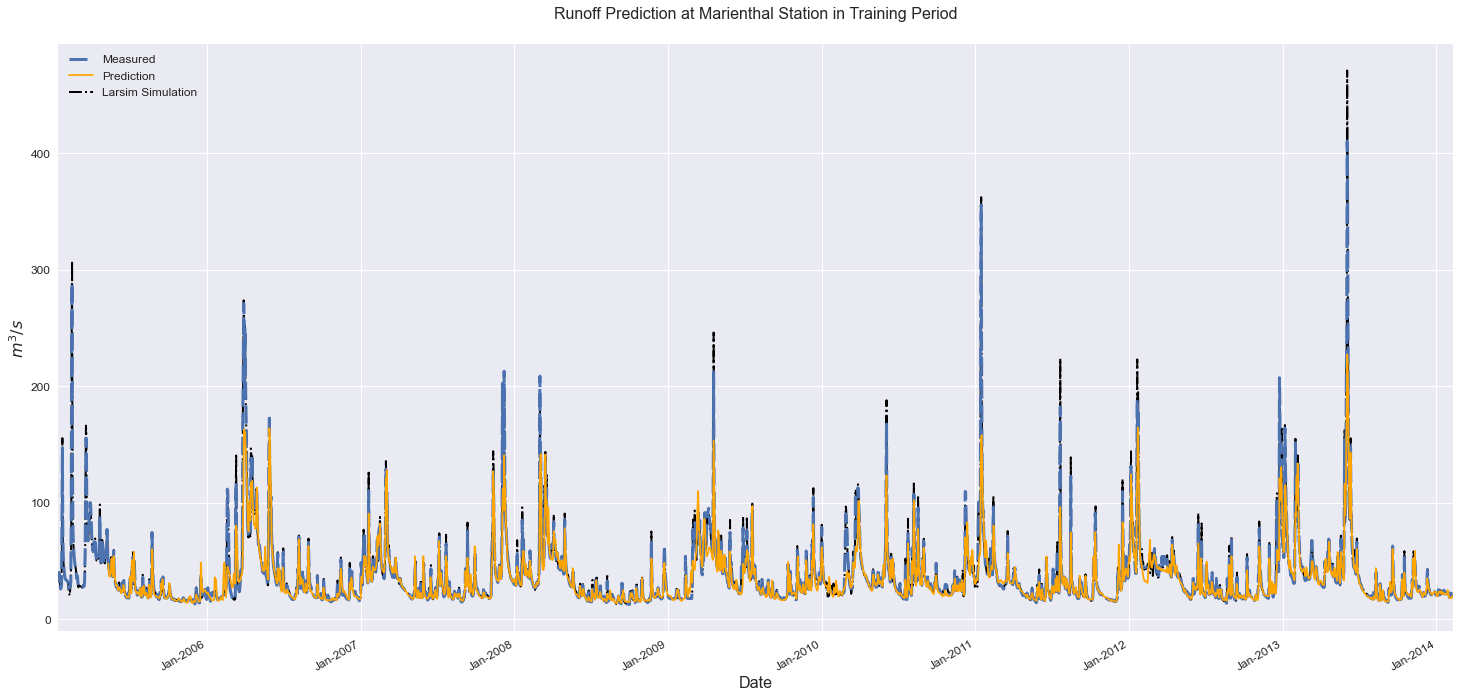

In [21]:
# Compare Runoff for Training Period
fig = gUF.compare_discharge_plot(train_dataset['q'], train_y_predict_inversed, Larsim_train, 'Runoff Prediction at Marienthal Station in Training Period', WINDOW_SIZE)

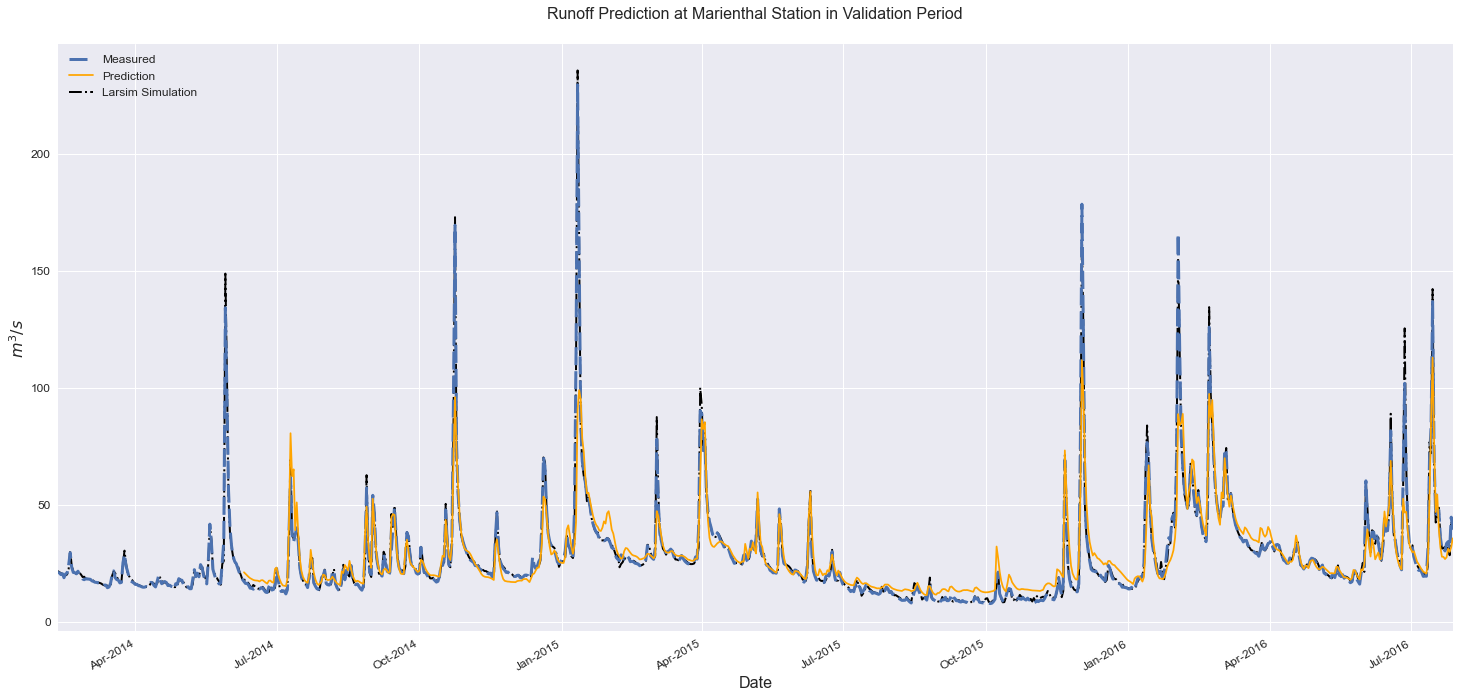

In [22]:
# Compare Runoff for Validation Period
fig = gUF.compare_discharge_plot(val_dataset['q'], val_y_predict_inversed, Larsim_val, 'Runoff Prediction at Marienthal Station in Validation Period', WINDOW_SIZE)

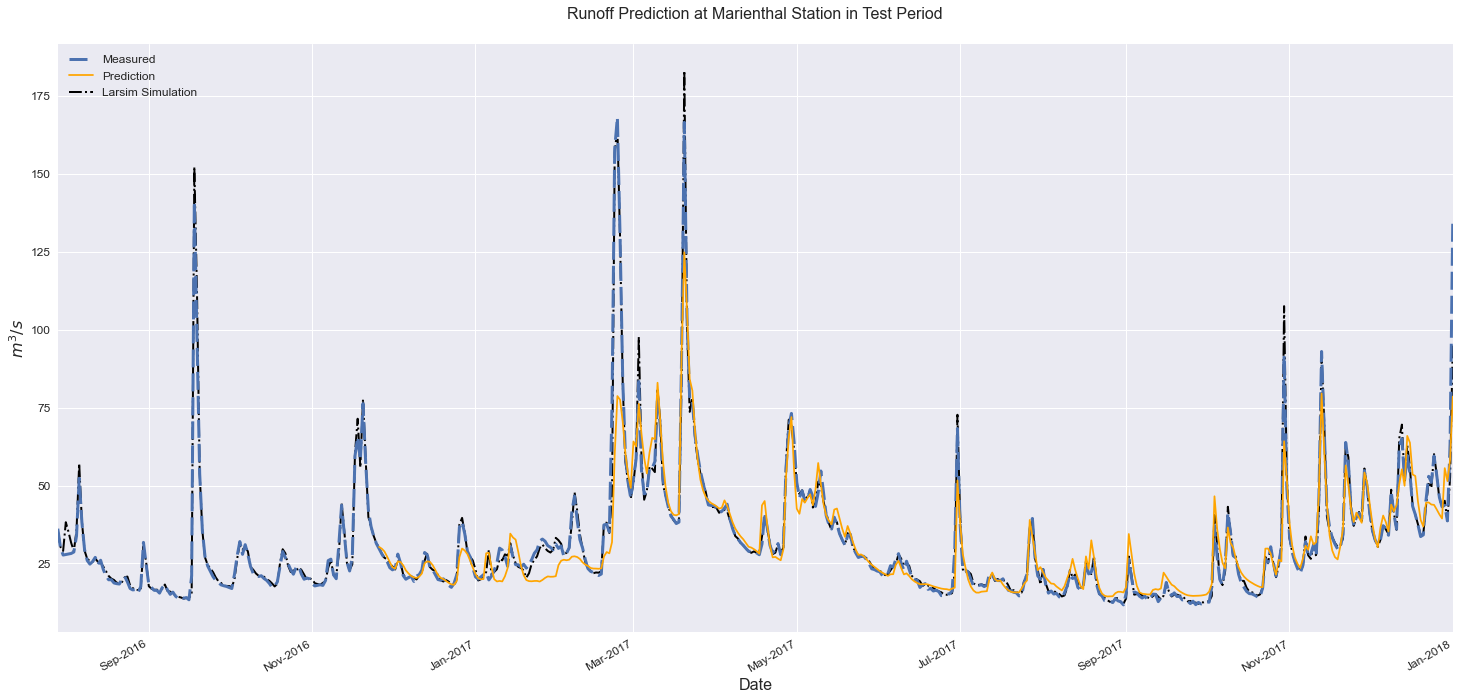

In [23]:
# Compare Runoff for Test Period
fig = gUF.compare_discharge_plot(test_dataset['q'], test_y_predict_inversed, Larsim_test, 'Runoff Prediction at Marienthal Station in Test Period', WINDOW_SIZE)

Test with plotly and complete predicted timeseries

In [24]:
# Make Predictions on complete scaled data
# Create scaled and windowed data of complete time period in one dataset
scaler_ = preprocessing.StandardScaler(with_mean=True, with_std=True)
dataset_scaled = scaler_.fit_transform(df)
fill_value = -7.0
np.nan_to_num(dataset_scaled, copy= False, nan= fill_value)

# Split Training/Validation/Test Dataset into input features and target values/labels
data_x, data_y = gUF.windowed_data(dataset_scaled, dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)

predicted_y = model.predict(data_x).flatten()
predicted_y_inversed = predicted_y * np.sqrt(scaler_.var_[-1]) + scaler_.mean_[-1]
# print(train_y_predict_2.shape)

# Evaluate the model on complete dataset
# Performance_total_inversed = gUF.performance_metrics(df['q'].iloc[WINDOW_SIZE:,-1].values, predicted_y_inversed, 'All', precision= 5)
# for key, value in Performance_total_inversed.items():
#     print(key,':', value)

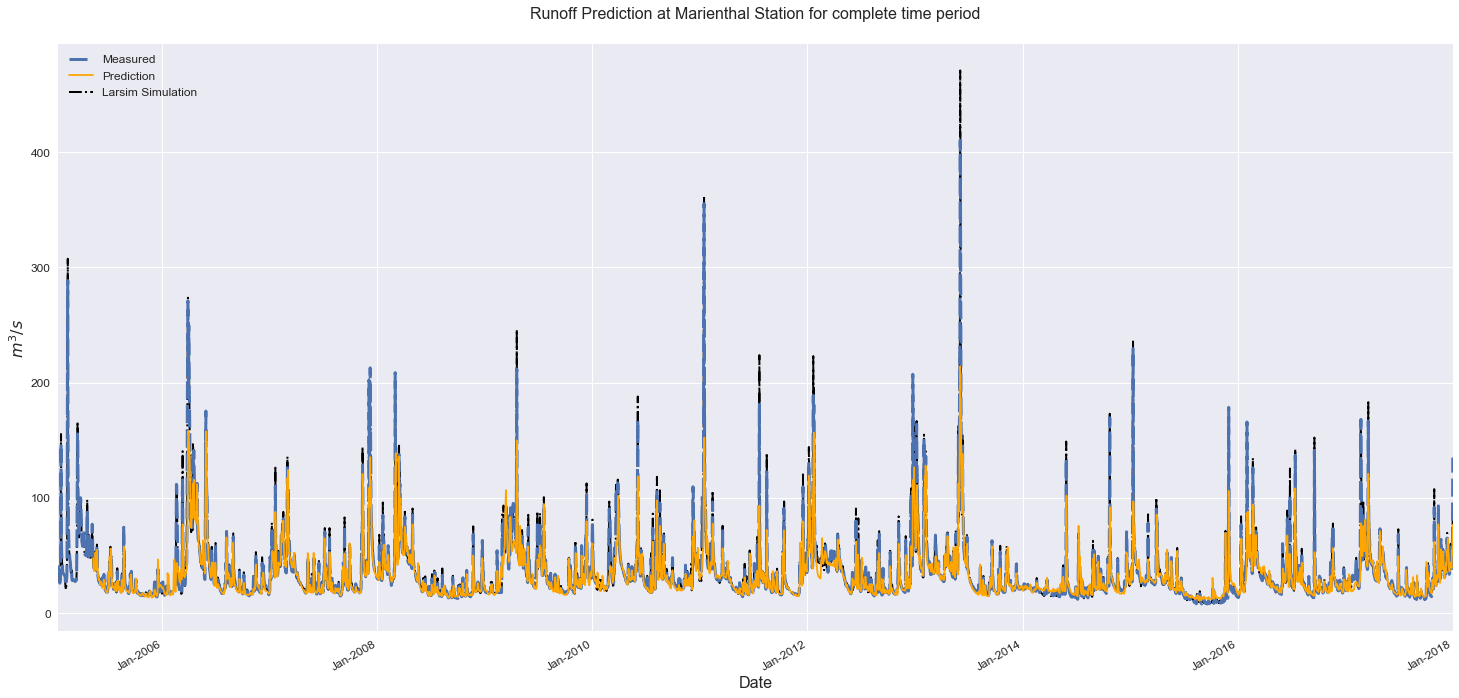

In [25]:
fig_complete = gUF.compare_discharge_plot(
        df["q"],
        predicted_y_inversed,
        Larsim_simulations_daily['MARI'],
        "Runoff Prediction at Marienthal Station for complete time period",
        WINDOW_SIZE,
    )

In [26]:
# Plot Discharge for complete Period (interpolated)
# Plot Discharge for complete Period (interpolated)
fig = go.Figure()
fig.add_trace(go.Scatter(x=Larsim_simulations.index, y=Larsim_simulations['MARI'], name= '<b>Larsim-Simulation - MARI Station</b>', opacity=1, mode='lines', line=go.scatter.Line(color= "black", dash='dashdot')))
fig.add_trace(go.Scatter(x=DATA.index, y=DATA['q']['MARI'], name= '<b>Discharge measured - MARI Station</b>', opacity=1, mode='lines', line=go.scatter.Line(color= "royalblue", dash='6,2')))
fig.add_trace(go.Scatter(x=df['q'].iloc[WINDOW_SIZE:,-1].index, y=predicted_y_inversed, name = '<b>Predicted by Model - MARI Station</b>', opacity=1, mode='lines', line=go.scatter.Line(color= "orange")))

fig.update_layout(xaxis=dict(rangeselector=dict(buttons=list([dict(count=1,label="1m",step="month",stepmode="backward"),dict(count=6,label="6m",step="month",stepmode="backward"),dict(count=WINDOW_SIZE,label="Window",step="day",stepmode="backward"),dict(count=1,label="1y",step="year",stepmode="backward"),dict(step="all")]))),
title_text="Discharge Comparison - MARI Station", xaxis_rangeslider_visible=True, yaxis_autorange= True, yaxis_fixedrange=False, width= 1300,height=600)
fig.show()

In [27]:
# Evaluate Larsim Performance
# impute missing values in Larsim simulation --> linear interpolation
Larsim_simulations['MARI'].interpolate(method='time', axis=0, limit=None, inplace=True, limit_direction='both')
Performance_Larsim = gUF.performance_metrics(df['q'].iloc[WINDOW_SIZE:].values, Larsim_simulations['MARI'].iloc[WINDOW_SIZE:].values, 'All', precision= 5)
for key, value in Performance_Larsim.items():
    print(key,':', value)

MAX_ERROR : 60.74455
MAE : 1.30362
MSE : 8.66029
RMSE : 2.94284
MeAE : 0.58958
REV : 0.39772
NSE : 0.98791
KGNP : 0.99115


## Plot Discharge after different Epochs

In [28]:
# Standard Scaling
# Missing Values Method:
# Option 2: Fill Missing Values with unphysical values
# Option 3: Fill missing values but mask them out inside the model -> used model will change
option_missing = 2
# Validation Method: normal HOLDOUT

In [ ]:
# General Settings --> adapt according to daily/hourly data
shuffle_buffer = 10000
WINDOW_SIZE = 120       # Vishakh: 120
BATCH_SIZE = 20         # Vishakh: 10
target_step = 1     # predict next day

In [29]:
# Model Settings
num_LSTM_units = 120    # Vishakh: 120
EPOCHS = 25             # Vishakh: 25
loss_function = 'MAE'
lstm_layers = 2

In [30]:
# Missing Values - Method 2 and 3 (TARGET INCLUDED)
if with_target == True:
    # Splitting the Dataset by Size
    training_size = int(len(df) * 0.70)
    validation_size = int(len(df) * 0.19)
    train_dataset, val_dataset, test_dataset = gUF.train_val_test_split(df, (training_size, validation_size), None, validation=True)

    # Scale the data
    scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
    train_dataset_scaled = scaler.fit_transform(train_dataset) 
    val_dataset_scaled = scaler.transform(val_dataset)
    test_dataset_scaled = scaler.transform(test_dataset)

    # Fill values after Scaling
    fill_value = -7.0
    np.nan_to_num(train_dataset_scaled, copy= False, nan= fill_value)
    np.nan_to_num(val_dataset_scaled, copy= False, nan= fill_value)
    np.nan_to_num(test_dataset_scaled, copy= False, nan= fill_value)

    # Split Training/Validation/Test Dataset into input features and target values/labels
    train_x, train_y = gUF.windowed_data(train_dataset_scaled, train_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)
    val_x, val_y = gUF.windowed_data(val_dataset_scaled, val_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)
    test_x, test_y = gUF.windowed_data(test_dataset_scaled, test_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)

    # Combine resulting features and lables into one Tensor consisting of shuffled batches
    training_data = gUF.batched_dataset(train_x, train_y, BATCH_SIZE, shuffle_buffer, 'training', repeat=True)
    validation_data = gUF.batched_dataset(val_x, val_y, BATCH_SIZE, shuffle_buffer, 'validation', repeat=True)
    testing_data = gUF.batched_dataset(test_x, test_y, BATCH_SIZE, shuffle_buffer, 'testing', repeat=True)
else: 
    # Missing Values - Method 2 and 3 (TARGET EXCLUDED)
    # Splitting the Dataset by Size
    training_size = int(len(df) * 0.70)
    validation_size = int(len(df) * 0.19)
    train_dataset, val_dataset, test_dataset = gUF.train_val_test_split(df, (training_size, validation_size), None, validation=True)

    # Scale the data
    scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
    train_dataset_scaled = scaler.fit_transform(train_dataset) 
    val_dataset_scaled = scaler.transform(val_datset)
    test_dataset_scaled = scaler.transform(test_dataset)

    # Fill values after Scaling
    fill_value = -7.0
    np.nan_to_num(train_dataset_scaled, copy= False, nan= fill_value)
    np.nan_to_num(val_dataset_scaled, copy= False, nan= fill_value)
    np.nan_to_num(test_dataset_scaled, copy= False, nan= fill_value)

    # Split Training/Validation/Test Dataset into input features and target values/labels
    train_x, train_y = gUF.windowed_data(train_dataset_scaled[:,:-1], train_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)
    val_x, val_y = gUF.windowed_data(val_dataset_scaled[:,:-1], val_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)
    test_x, test_y = gUF.windowed_data(test_dataset_scaled[:,:-1], test_dataset_scaled[:,-1], WINDOW_SIZE, target_step, single_step=True)

    # Combine resulting features and lables into one Tensor consisting of shuffled batches
    training_data = gUF.batched_dataset(train_x, train_y, BATCH_SIZE, shuffle_buffer, 'training', repeat=True)
    validation_data = gUF.batched_dataset(val_x, val_y, BATCH_SIZE, shuffle_buffer, 'validation', repeat=True)
    testing_data = gUF.batched_dataset(test_x, test_y, BATCH_SIZE, shuffle_buffer, 'testing', repeat=True) 

In [31]:
# OPTIONAL
# checking the number of necessary(minimum) evaluation steps and validation steps --> This Cell is only needed when the input Dataset is a Repeated Dataset 
# Ensure that the whole the different datasets are used completely: steps_per_epoch = (len(dataset) - WINDOW_SIZE)//(BATCH_SIZE)
steps_in_one_epoch = (len(train_dataset) - WINDOW_SIZE)//(BATCH_SIZE)
print(steps_in_one_epoch)
validation_steps_after_one_epoch = (len(val_dataset) - WINDOW_SIZE)//(BATCH_SIZE)
print(validation_steps_after_one_epoch)
testing_steps = (len(test_dataset) - WINDOW_SIZE)//(BATCH_SIZE)
print(testing_steps)

# Set the evaluation interval manually --> steps (batches of samples = batch_size * steps)
# default values --> each batch of samples of the datasets are exaclty shown once to the model 
TRAINING_INTERVAL = steps_in_one_epoch
VALUATION_INTERVAL = validation_steps_after_one_epoch
TEST_INTERVAL = testing_steps

159
39
20


In [32]:
# check Dimensions

# train_dataset --> complete Training Dataset after splitting 
print(len(train_dataset))

# val_dataset --> dataset used for validation during fitting of the model
print(len(val_dataset)) # resulting period (i.e. how often do the window fit completetly into the training data): length of the training data - window-size - 1

# test_dataset --> complete Testing Dataset after splitting
print(len(test_dataset))

# check lengths
print('Sum:',len(test_dataset) + len(val_dataset) + len(train_dataset)) # must be equal to the time period of the complete input dataframe
print('_____________________________________')
print(train_x.shape) #(resulting period, window_size, # of input features)
print(val_x.shape) #(resulting period, window_size, # of input features)
print(test_x.shape) #(resulting period, window_size, # of input features)
print('_____________________________________')
# Get coorect input shape for the first layer of the NN
# for LSTM (window_size, # features)
SHAPE = train_x.shape[-2:] 
print('Input_Shape for LSTM:',SHAPE)

3317
900
522
Sum: 4739
_____________________________________
(3197, 120, 33)
(780, 120, 33)
(402, 120, 33)
_____________________________________
Input_Shape for LSTM: (120, 33)


### Model that is not trained (Epoch 0)

In [33]:
# Clear Cache and use random seed for reproducability
tf.keras.backend.clear_session()
tf.random.set_seed(7)

# Create and compile Model
if lstm_layers ==  1:
    if option_missing == 3:
        model_0_Epochs = gUF.get_changed_model(lstm_layers, num_LSTM_units, SHAPE, loss_function, fill_value, masked= True)
    else:
        model_0_Epochs = gUF.get_changed_model(lstm_layers, num_LSTM_units, SHAPE, loss_function, fill_value, masked= False)
if lstm_layers == 2:
    if option_missing == 3: 
        model_0_Epochs = gUF.get_model_vishakh_masked(num_LSTM_units, SHAPE, loss_function, fill_value)
    else:
        model_0_Epochs = gUF.get_model_vishakh(num_LSTM_units, SHAPE, loss_function)
if lstm_layers ==  3:
    if option_missing == 3:
        model_0_Epochs = gUF.get_changed_model(lstm_layers, num_LSTM_units, SHAPE, loss_function, fill_value, masked= True)
    else: 
        model_0_Epochs = gUF.get_changed_model(lstm_layers, num_LSTM_units, SHAPE, loss_function, fill_value, masked= False)

In [34]:
# Make Prediction on windowed datasets
train_y_predict = model_0_Epochs.predict(train_x).flatten()
val_y_predict = model_0_Epochs.predict(val_x).flatten()
test_y_predict = model_0_Epochs.predict(test_x).flatten()

In [35]:
# inverse the predicted values
# if standard scaler was used
train_y_predict_inversed_0 = train_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]
val_y_predict_inversed_0 = val_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]
test_y_predict_inversed_0 = test_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]

### Model that is trained for 2 Epochs

In [36]:
# Clear Cache and use random seed for reproducability
tf.keras.backend.clear_session()
tf.random.set_seed(7)

# Create and compile Model
if lstm_layers ==  1:
    if option_missing == 3:
        model_2_Epochs = gUF.get_changed_model(lstm_layers, num_LSTM_units, SHAPE, loss_function, fill_value, masked= True)
    else:
        model_2_Epochs = gUF.get_changed_model(lstm_layers, num_LSTM_units, SHAPE, loss_function, fill_value, masked= False)
if lstm_layers == 2:
    if option_missing == 3: 
        model_2_Epochs = gUF.get_model_vishakh_masked(num_LSTM_units, SHAPE, loss_function, fill_value)
    else:
        model_2_Epochs = gUF.get_model_vishakh(num_LSTM_units, SHAPE, loss_function)
if lstm_layers ==  3:
    if option_missing == 3:
        model_2_Epochs = gUF.get_changed_model(lstm_layers, num_LSTM_units, SHAPE, loss_function, fill_value, masked= True)
    else: 
        model_2_Epochs = gUF.get_changed_model(lstm_layers, num_LSTM_units, SHAPE, loss_function, fill_value, masked= False)

In [37]:
# Implement Learning Rate Scheduler --> look for range of a good learning rate
callbacks = tf.keras.callbacks.LearningRateScheduler(gUF.lr_schedule)
# Fit the Model
history = model_2_Epochs.fit(training_data, epochs= 2, verbose=1, steps_per_epoch=TRAINING_INTERVAL, validation_data= validation_data, validation_steps=VALUATION_INTERVAL, callbacks=[callbacks])

Epoch 1/2
159/159 [==============================] - 7s 46ms/step - loss: 0.3079 - mse: 0.5519 - root_mean_squared_error: 0.7429 - val_loss: 0.2226 - val_mse: 0.2391 - val_root_mean_squared_error: 0.4890 - lr: 0.0010
Epoch 2/2
159/159 [==============================] - 7s 43ms/step - loss: 0.2563 - mse: 0.4287 - root_mean_squared_error: 0.6548 - val_loss: 0.2042 - val_mse: 0.2101 - val_root_mean_squared_error: 0.4584 - lr: 0.0010


In [38]:
# Make Prediction on windowed datasets
train_y_predict = model_2_Epochs.predict(train_x).flatten()
val_y_predict = model_2_Epochs.predict(val_x).flatten()
test_y_predict = model_2_Epochs.predict(test_x).flatten()

In [39]:
# inverse the predicted values
# if standard scaler was used
train_y_predict_inversed_2 = train_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]
val_y_predict_inversed_2 = val_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]
test_y_predict_inversed_2 = test_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]

### Model that is trained for 25 Epochs

In [40]:
# use loaded model from above
model_25_epochs = model

In [41]:
# Make Prediction on windowed datasets
train_y_predict = model_25_epochs.predict(train_x).flatten()
val_y_predict = model_25_epochs.predict(val_x).flatten()
test_y_predict = model_25_epochs.predict(test_x).flatten()

In [42]:
# inverse the predicted values
# if standard scaler was used
train_y_predict_inversed_25 = train_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]
val_y_predict_inversed_25 = val_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]
test_y_predict_inversed_25 = test_y_predict * np.sqrt(scaler.var_[-1]) + scaler.mean_[-1]

Create Dataframe with all predicted values after different epochs

In [43]:
dict_epochs_train = {'Epoch_0': train_y_predict_inversed_0, 'Epoch_2': train_y_predict_inversed_2, 'Epoch_25': train_y_predict_inversed_25}
dict_epochs_val = {'Epoch_0': val_y_predict_inversed_0, 'Epoch_2': val_y_predict_inversed_2, 'Epoch_25': val_y_predict_inversed_25}
dict_epochs_test = {'Epoch_0': test_y_predict_inversed_0, 'Epoch_2': test_y_predict_inversed_2, 'Epoch_25': test_y_predict_inversed_25}

In [44]:
Predicted_after_epochs_train = pd.DataFrame(dict_epochs_train, index=train_dataset.index[WINDOW_SIZE:])
Predicted_after_epochs_val = pd.DataFrame(dict_epochs_val, index=val_dataset.index[WINDOW_SIZE:])
Predicted_after_epochs_test = pd.DataFrame(dict_epochs_test, index=test_dataset.index[WINDOW_SIZE:])

Vizualize Results

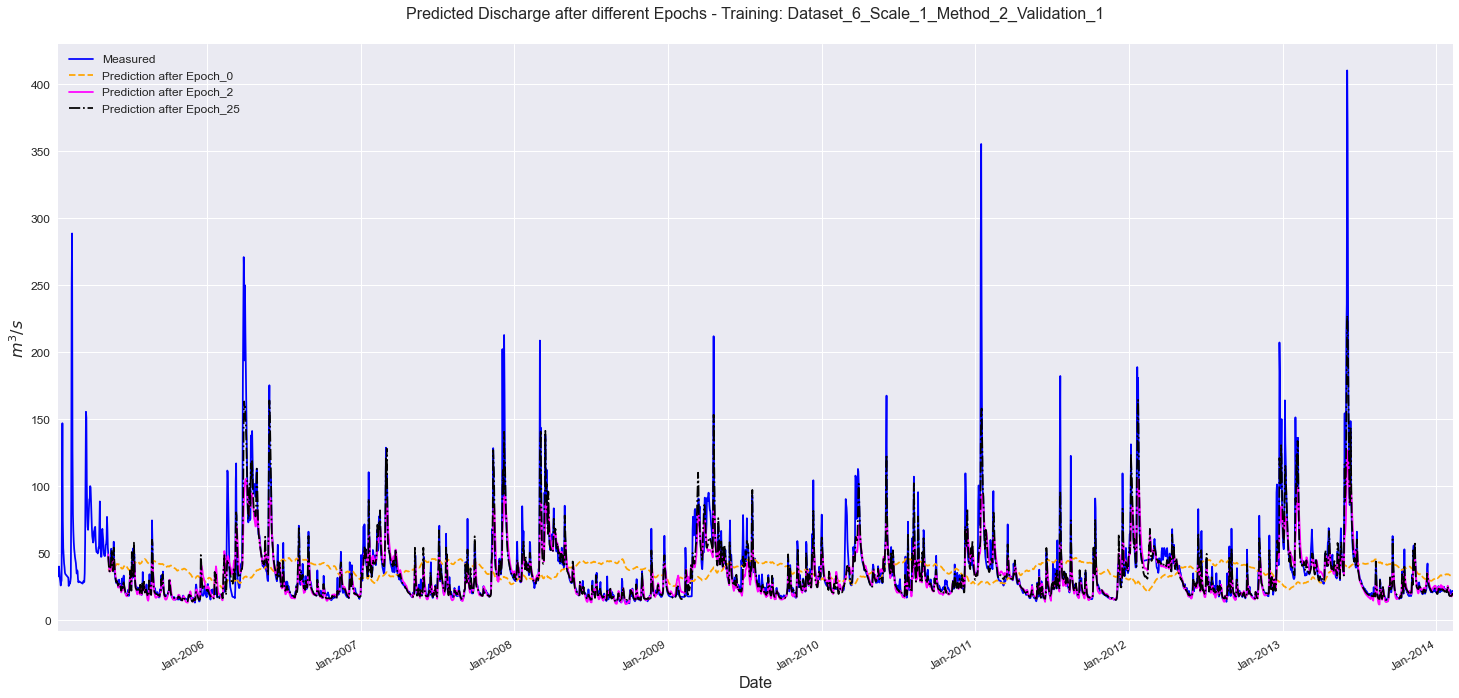

In [46]:
# Training Period
f = gUF.compare_discharge_plot_epochs(train_dataset['q'], Predicted_after_epochs_train, 'Predicted Discharge after different Epochs - Training: ' + dataset, WINDOW_SIZE)

f.savefig("C:/Users/leonf/Documents/Python/Masterthesis-Leon/Figures/Model_different_epochs/"
        + "Discharge_comparison - Training"
        + ".jpg",
        bbox_inches='tight', dpi= 1200, facecolor= 'white')

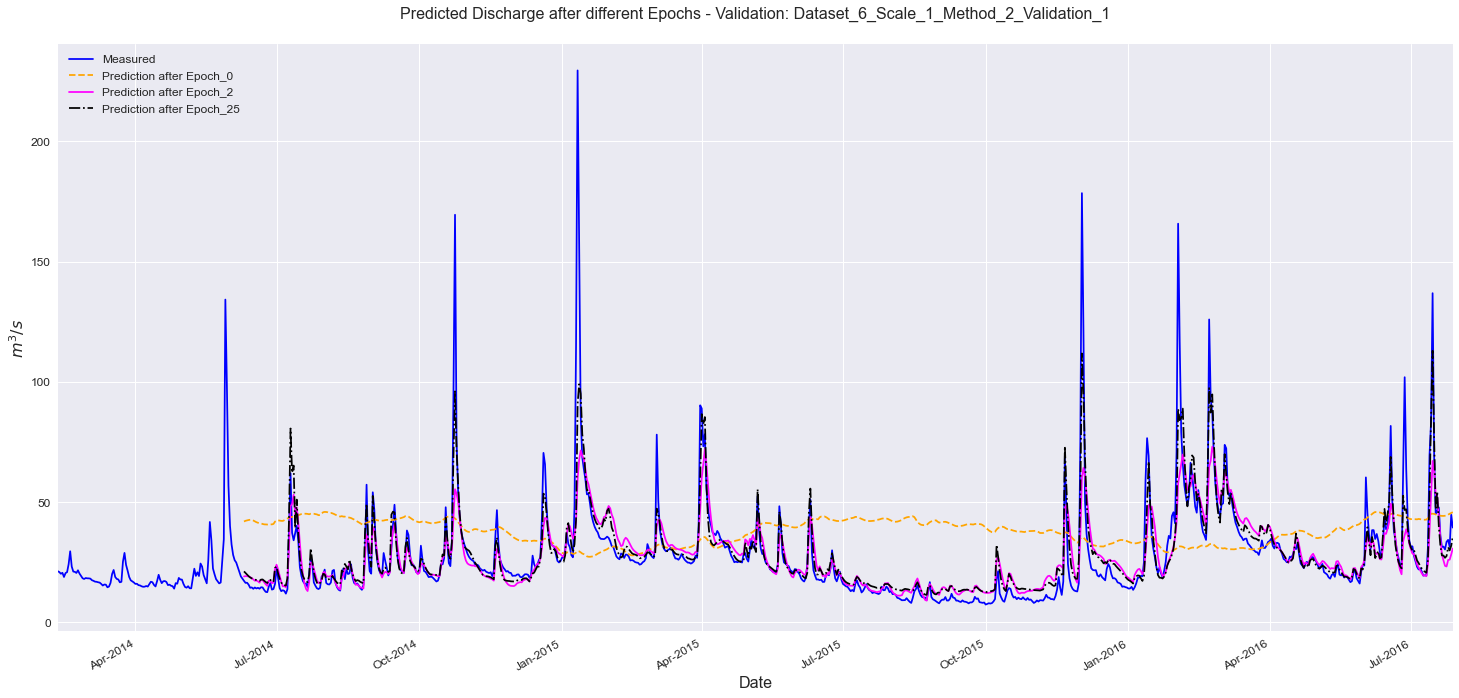

In [47]:
# Validation Period
f = gUF.compare_discharge_plot_epochs(val_dataset['q'], Predicted_after_epochs_val, 'Predicted Discharge after different Epochs - Validation: ' + dataset, WINDOW_SIZE)

f.savefig("C:/Users/leonf/Documents/Python/Masterthesis-Leon/Figures/Model_different_epochs/"
        + "Discharge_comparison - Validation"
        + ".jpg",
        bbox_inches='tight', dpi= 1200, facecolor= 'white')

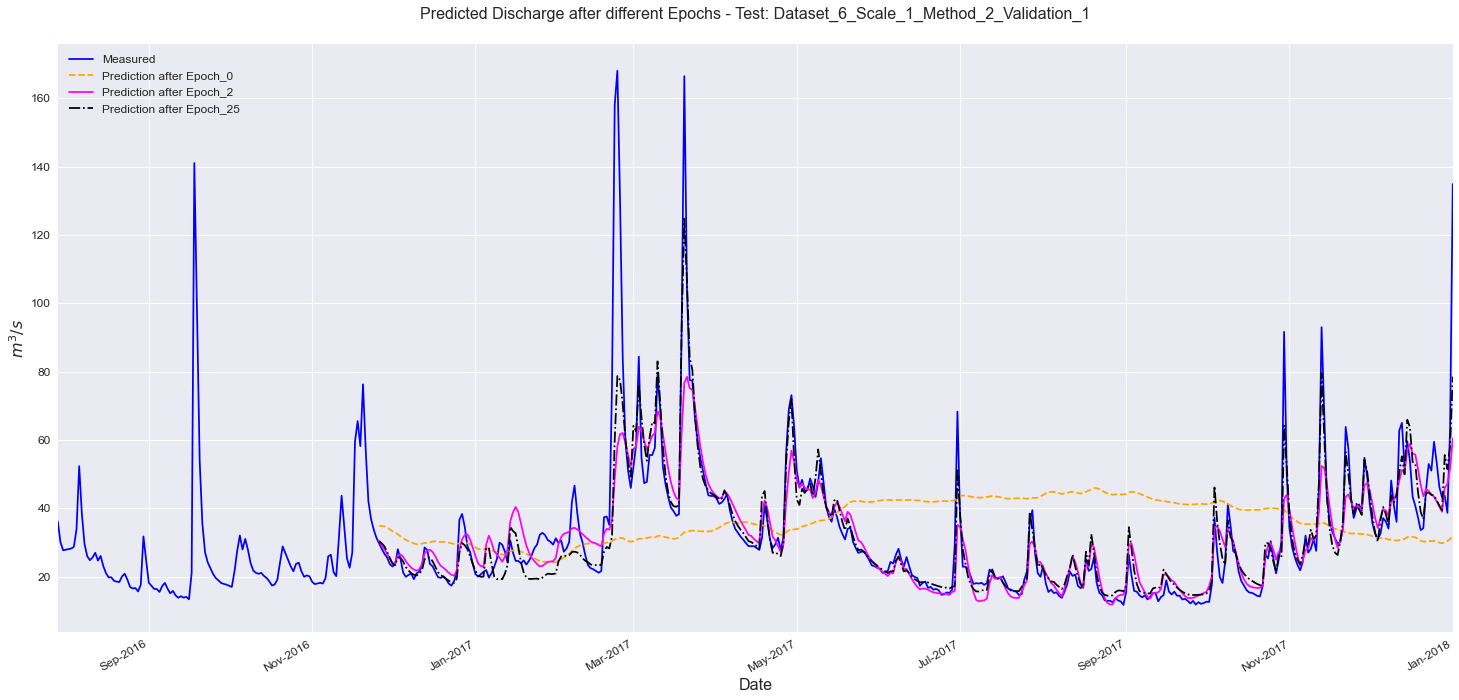

In [48]:
# Test Period
f = gUF.compare_discharge_plot_epochs(test_dataset['q'], Predicted_after_epochs_test, 'Predicted Discharge after different Epochs - Test: ' +  dataset, WINDOW_SIZE)

f.savefig("C:/Users/leonf/Documents/Python/Masterthesis-Leon/Figures/Model_different_epochs/"
        + "Discharge_comparison - Test"
        + ".jpg",
        bbox_inches='tight', dpi= 1200, facecolor= 'white')